<a href="https://colab.research.google.com/github/naenumtou/creditrisk/blob/main/TitanicAppModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Set auto reload
%reload_ext autoreload
%autoreload 2

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import warnings

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import mean_squared_error
from scipy import stats

# Config display
%config InlineBackend.figure_format = 'retina'
warnings.filterwarnings('ignore') #Off warnings

In [3]:
# Import dataset
df = pd.read_csv(
    'https://raw.githubusercontent.com/naenumtou/creditrisk/main/datasets/titanic_data.csv'
)

# Drop un-used columns
df = df.drop(['Name','Ticket','Cabin'], axis = 1)
df.head(5)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,male,22.0,1,0,7.2500,S
1,2,1,1,female,38.0,1,0,71.2833,C
2,3,1,3,female,26.0,0,0,7.9250,S
3,4,1,1,female,35.0,1,0,53.1000,S
4,5,0,3,male,35.0,0,0,8.0500,S


In [ ]:
'''
Data dictionary
Survived: 0 = No, 1 = Yes
Pclass: Ticket class - 1 = 1st, 2 = 2nd, 3 = 3rd
SibSp: # of siblings / spouses aboard the Titanic
Parch: # of parents / children aboard the Titanic
Fare: Passenger fare
Embarked: Port of Embarkation - C = Cherbourg, Q = Queenstown, S = Southampton
'''

In [5]:
# Data gap analysis
# Missing values
print('Checking missing data')
print(df.isnull().sum())

# 'Age' is missing: 177
# 'Embarked' is missing: 2

Checking missing data
PassengerId      0
Survived         0
Pclass           0
Sex              0
Age            177
SibSp            0
Parch            0
Fare             0
Embarked         2
dtype: int64


In [6]:
# Numeric variables checking
df.describe().T

,count,mean,std,min,25%,50%,75%,max
PassengerId,891.0,446.000000,257.353842,1.00,223.5000,446.0000,668.5,891.0000
Survived,891.0,0.383838,0.486592,0.00,0.0000,0.0000,1.0,1.0000
Pclass,891.0,2.308642,0.836071,1.00,2.0000,3.0000,3.0,3.0000
Age,714.0,29.699118,14.526497,0.42,20.1250,28.0000,38.0,80.0000
SibSp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000
Parch,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.0000
Fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292


In [7]:
# 'Age' and 'Fare'
age_sample = df.loc[df['Age'] < 1]['PassengerId'].count()
fare_sample = df.loc[df['Fare'] == 0]['PassengerId'].count()
print(f'Age equal to 0 is {age_sample}')
print(f'Fare equal to 0 is {fare_sample}')

# 'Age' less than 0 might be baby born
# 'Fare' is equal to 0 might be free ticket
# Both cases will be ignored

Age equal to 0 is 7
Fare equal to 0 is 15


In [8]:
# Investigation for missing data
# 'Age' 177 passengers is missing age - will be filled with 'mode'
df['Age'] = df['Age'].fillna(df['Age'].mode()[0])

# 'Embarked' 2 passengers is missing age - will be filled with 'mode'
df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])

In [9]:
# Re-performed data gap analysis
print('Checking missing data')
print(df.isnull().sum())

Checking missing data
PassengerId    0
Survived       0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
dtype: int64


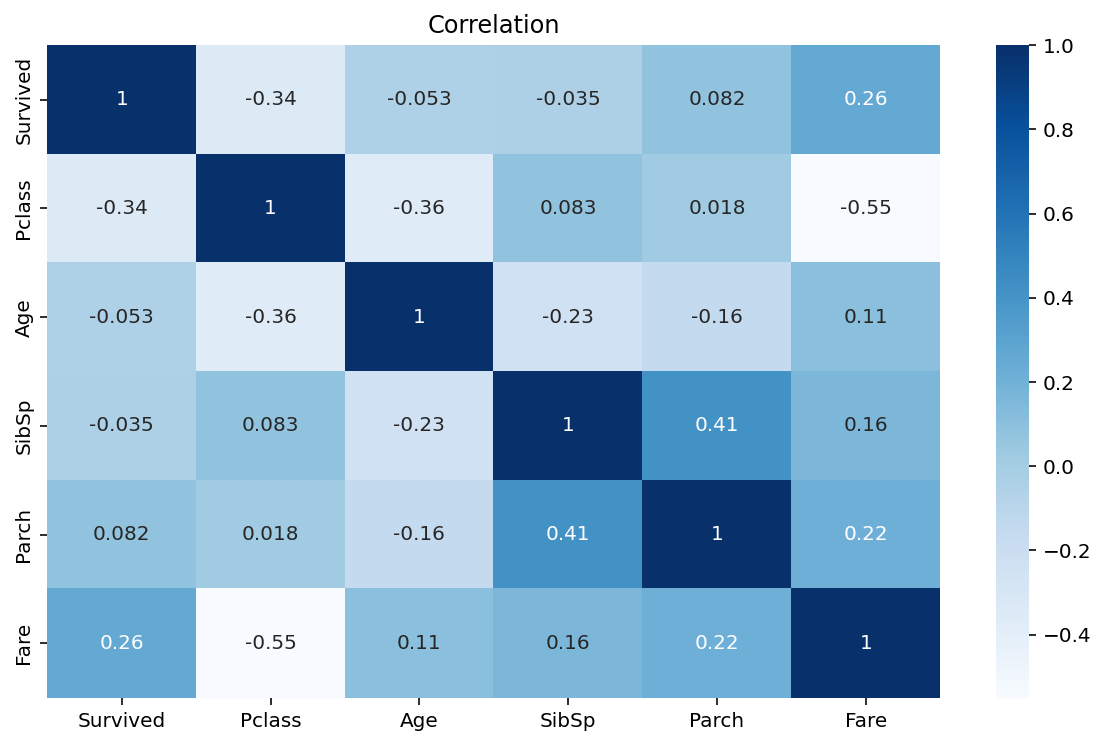

In [10]:
# Single factor analysis - correlation
df_corr = df.drop(['PassengerId'], axis = 1)
df_corr = df_corr.corr()

# Plot
plt.figure(figsize = (10, 6))
sns.heatmap(
    df_corr,
    annot = True,
    cmap = plt.cm.Blues
)
plt.title('Correlation')
plt.show()

In [11]:
# Factor binning
nums = ['Age', 'Fare'] #Numeric variables

for n in nums:
  ranking = pd.qcut(
      df[n],
      10,
      duplicates = 'drop'
  )
  ranking = pd.DataFrame(ranking)
  ranking = ranking.rename(columns = {n: f'{n}_bin'})
  df = pd.merge(
      df,
      ranking,
      how = 'left',
      left_index = True,
      right_index = True
  )
  df[f'{n}_bin'] = df[f'{n}_bin'].astype(str)

In [12]:
# WOE and IV Transformation
# Define IV Function
def IV(x):
  iv = x.groupby(['Factors'])['IV'].sum()
  return print(iv)

facs = [
        'Pclass',
        'Sex',
        'SibSp',
        'Parch',
        'Embarked',
        'Age_bin',
        'Fare_bin'
]

factors_summary = []

for f in facs:
  binning = pd.concat(
      [
       df.groupby([f])['Survived'].count(),
       df.groupby([f])['Survived'].sum()
      ],
      axis = 1,
       keys = ['N', 'Survived']
  ).rename_axis('Binning').reset_index()
  binning['Survived_rate'] = binning['Survived'] / binning['N']
  binning['Factors'] = str(f)
  binning['Non_survived'] = binning['N'] - binning['Survived']
  binning['%Survived'] = binning['Survived'] / binning['Survived'].sum()
  binning['%Non_survived'] = binning['Non_survived'] / binning['Non_survived'].sum()
  binning['WOE'] = np.log(binning['%Survived'] / binning['%Non_survived'])
  binning['IV'] = (binning['%Survived'] - binning['%Non_survived']) * binning['WOE']
  factors_summary.append(binning)

factors_summary = pd.concat(
    factors_summary,
    ignore_index = True,
    sort = False
)

# IV
IV(factors_summary) #inf IV due to 0 valus in target - need to be adjusted

Factors
Age_bin     0.097745
Embarked    0.119923
Fare_bin    0.625860
Parch            inf
Pclass      0.500950
Sex         1.341681
SibSp            inf
Name: IV, dtype: float64


In [13]:
# Coarse-Classing
# 'SibSp'
condition = df['SibSp'] == 0
df['SibSp_bin'] = np.where(condition, 0, 1)

# 'Parch'
condition = df['Parch'] == 0
df['Parch_bin'] = np.where(condition, 0, 1)

In [14]:
# Re-calculation of WOE and IV Transformation
facs = ['Pclass','Sex','Embarked','Age_bin','Fare_bin','SibSp_bin','Parch_bin']
factors_summary = []

for f in facs:
  binning = pd.concat(
      [
       df.groupby([f])['Survived'].count(),
       df.groupby([f])['Survived'].sum()
      ],
      axis = 1,
       keys = ['N', 'Survived']
  ).rename_axis('Binning').reset_index()
  binning['Survived_rate'] = binning['Survived'] / binning['N']
  binning['Factors'] = str(f)
  binning['Non_survived'] = binning['N'] - binning['Survived']
  binning['%Survived'] = binning['Survived'] / binning['Survived'].sum()
  binning['%Non_survived'] = binning['Non_survived'] / binning['Non_survived'].sum()
  binning['WOE'] = np.log(binning['%Survived'] / binning['%Non_survived'])
  binning['IV'] = (binning['%Survived'] - binning['%Non_survived']) * binning['WOE']
  factors_summary.append(binning)
    
factors_summary2 = pd.concat(
    factors_summary,
    ignore_index = True,
    sort = False
)

# IV
IV(factors_summary2)

Factors
Age_bin      0.097745
Embarked     0.119923
Fare_bin     0.625860
Parch_bin    0.089718
Pclass       0.500950
Sex          1.341681
SibSp_bin    0.055999
Name: IV, dtype: float64


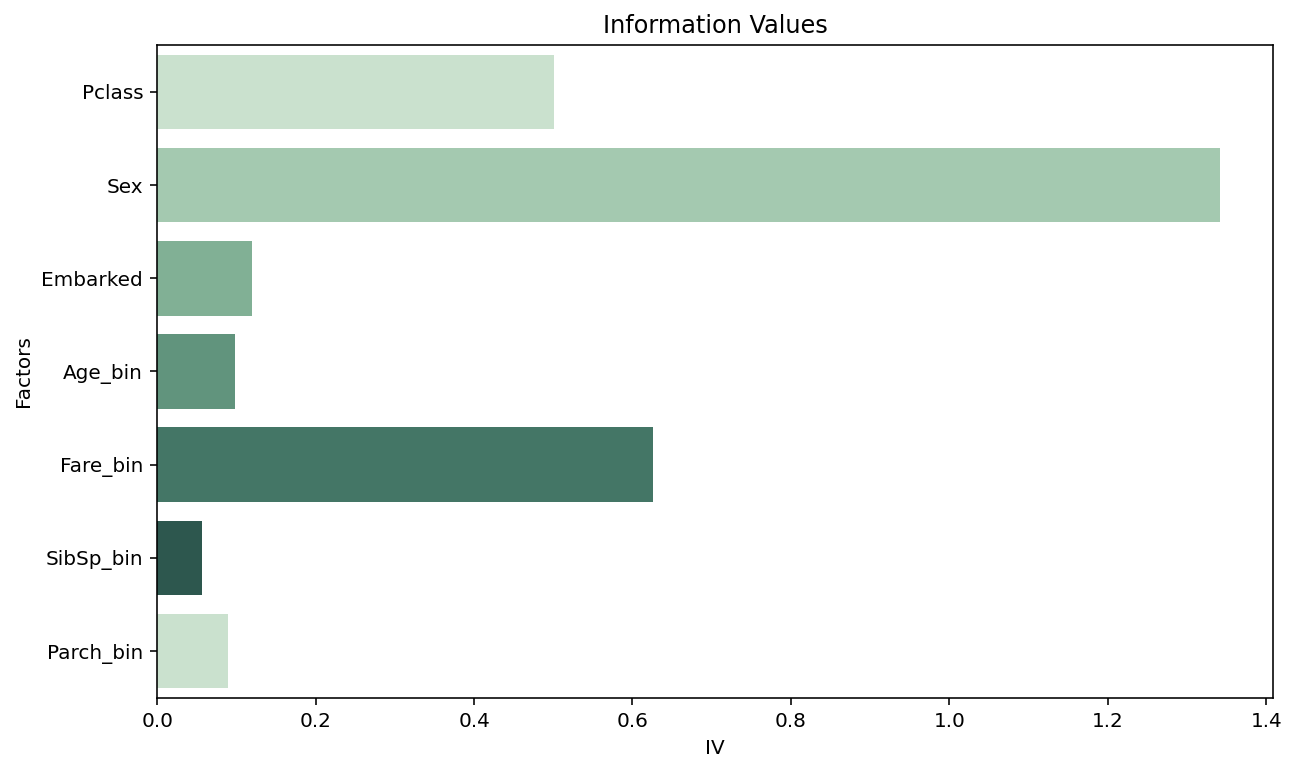

In [15]:
# Plot IV
plt.figure(figsize = (10, 6))
sns.barplot(
    x = 'IV',
    y = 'Factors',
    data = factors_summary2,
    palette = sns.color_palette('ch:2.5,-.2,dark=.3'),
    ci = None,
    estimator = sum
)
plt.title('Information Values')
plt.show()

In [16]:
# Mapping WOE
cols = list(set(factors_summary2['Factors']))

for c in cols:
  factor = factors_summary2[factors_summary2['Factors'] == c]
  df = pd.merge(
      df,
      factor[['Binning', 'WOE']],
      how = 'left',
      left_on = c,
      right_on = 'Binning'
  )
  df = df.drop(['Binning'], axis = 1)
  df = df.rename(columns = {'WOE': f'WOE_{c}'})

# Show table
df.head(5)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Age_bin,Fare_bin,SibSp_bin,Parch_bin,WOE_Embarked,WOE_SibSp_bin,WOE_Fare_bin,WOE_Pclass,WOE_Parch_bin,WOE_Age_bin,WOE_Sex
0,1,0,3,male,22.0,1,0,7.2500,S,"(20.0, 24.0]","(-0.001, 7.55]",1,0,-0.194425,0.338810,-1.331211,-0.666483,-0.173748,-0.280484,-0.983833
1,2,1,1,female,38.0,1,0,71.2833,C,"(32.5, 38.0]","(39.688, 77.958]",1,0,0.688399,0.338810,0.585766,1.003916,-0.173748,0.270347,1.529877
2,3,1,3,female,26.0,0,0,7.9250,S,"(24.0, 28.0]","(7.854, 8.05]",0,0,-0.194425,-0.166057,-1.048181,-0.666483,-0.173748,-0.132848,1.529877
3,4,1,1,female,35.0,1,0,53.1000,S,"(32.5, 38.0]","(39.688, 77.958]",1,0,-0.194425,0.338810,0.585766,1.003916,-0.173748,0.270347,1.529877
4,5,0,3,male,35.0,0,0,8.0500,S,"(32.5, 38.0]","(7.854, 8.05]",0,0,-0.194425,-0.166057,-1.048181,-0.666483,-0.173748,0.270347,-0.983833


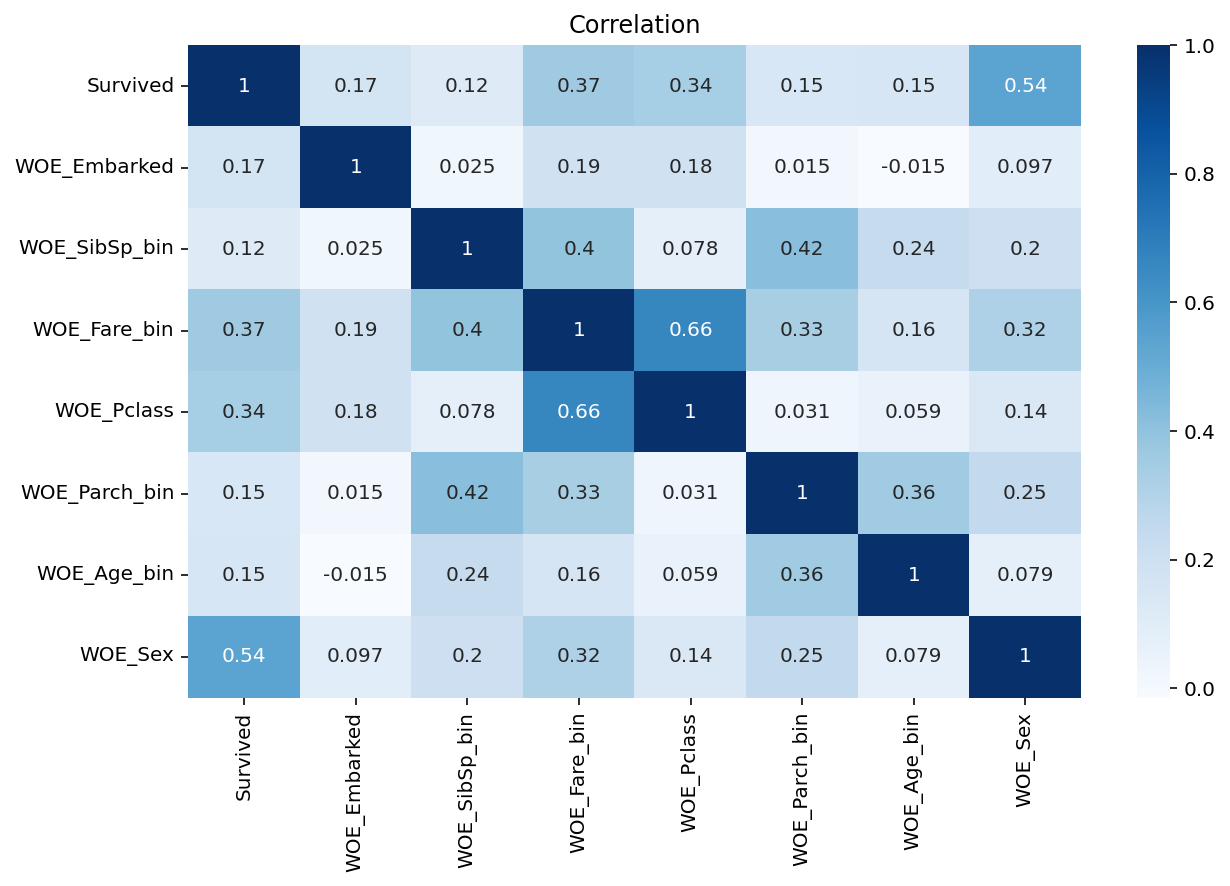

In [17]:
# Single factor analysis - correlation (with WOE)
p = 'WOE_'
x_cols = [p + s for s in cols]
all_cols = ['Survived'] + x_cols
df_corr = df[all_cols]
df_corr = df_corr.corr()

# Plot
plt.figure(figsize = (10, 6))
sns.heatmap(
    df_corr,
    annot = True,
    cmap = plt.cm.Blues
)
plt.title('Correlation')
plt.show()

In [18]:
# Train/Test split
train, test = train_test_split(df, test_size = 0.3, random_state = 17)
print(f'Training sample: {train.shape[0]}')
print(f'Validation sample: {test.shape[0]}')

Training sample: 623
Validation sample: 268


In [19]:
# Model logistic regression
# First round
model = sm.Logit(train['Survived'], sm.add_constant(train[x_cols]))
results = model.fit()
print(results.summary()) 

Optimization terminated successfully.
         Current function value: 0.431476
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:               Survived   No. Observations:                  623
Model:                          Logit   Df Residuals:                      615
Method:                           MLE   Df Model:                            7
Date:                Mon, 24 Jan 2022   Pseudo R-squ.:                  0.3456
Time:                        10:22:51   Log-Likelihood:                -268.81
converged:                       True   LL-Null:                       -410.79
Covariance Type:            nonrobust   LLR p-value:                 1.605e-57
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.5205      0.109     -4.778      0.000      -0.734      -0.307
WOE_Embarked      0.

In [20]:
# Drop not alined sign --> 'WOE_SibSp_bin' and 'WOE_Parch_bin'
x_cols.remove('WOE_SibSp_bin')
x_cols.remove('WOE_Parch_bin')

# Second round
model = sm.Logit(train['Survived'], sm.add_constant(train[x_cols]))
results = model.fit()
print(results.summary())

Optimization terminated successfully.
         Current function value: 0.434255
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:               Survived   No. Observations:                  623
Model:                          Logit   Df Residuals:                      617
Method:                           MLE   Df Model:                            5
Date:                Mon, 24 Jan 2022   Pseudo R-squ.:                  0.3414
Time:                        10:22:51   Log-Likelihood:                -270.54
converged:                       True   LL-Null:                       -410.79
Covariance Type:            nonrobust   LLR p-value:                 1.556e-58
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.5310      0.109     -4.893      0.000      -0.744      -0.318
WOE_Embarked     0.7380

In [21]:
# Drop factor having p-value > 0.05 --> 'WOE_Fare_bin'
x_cols.remove('WOE_Fare_bin')

# Third round
model = sm.Logit(train['Survived'], sm.add_constant(train[x_cols]))
results = model.fit()
print(results.summary())

Optimization terminated successfully.
         Current function value: 0.434751
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:               Survived   No. Observations:                  623
Model:                          Logit   Df Residuals:                      618
Method:                           MLE   Df Model:                            4
Date:                Mon, 24 Jan 2022   Pseudo R-squ.:                  0.3407
Time:                        10:22:51   Log-Likelihood:                -270.85
converged:                       True   LL-Null:                       -410.79
Covariance Type:            nonrobust   LLR p-value:                 2.366e-59
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.5314      0.108     -4.900      0.000      -0.744      -0.319
WOE_Embarked     0.7614

In [22]:
# Model performance
# Back-testing
actual_list = train['Survived'].tolist()
predictions_list = results.predict().tolist()

fpr, tpr, thresholds = roc_curve(actual_list, predictions_list)

y_train = pd.DataFrame(train['Survived'])
y_train['y_pred'] = results.predict()
ks = stats.ks_2samp(y_train[y_train['Survived'] == 0]['y_pred'], y_train[y_train['Survived'] == 1]['y_pred']).statistic

print(f'AUC: {auc(fpr, tpr):.4f}')
print(f'GINI: {(2 * auc(fpr, tpr)) - 1:.4f}')
print(f'KS: {ks:.4f}')
print(f'MSE: {mean_squared_error(actual_list, predictions_list):.4f}')

AUC: 0.8603
GINI: 0.7205
KS: 0.5802
MSE: 0.1365


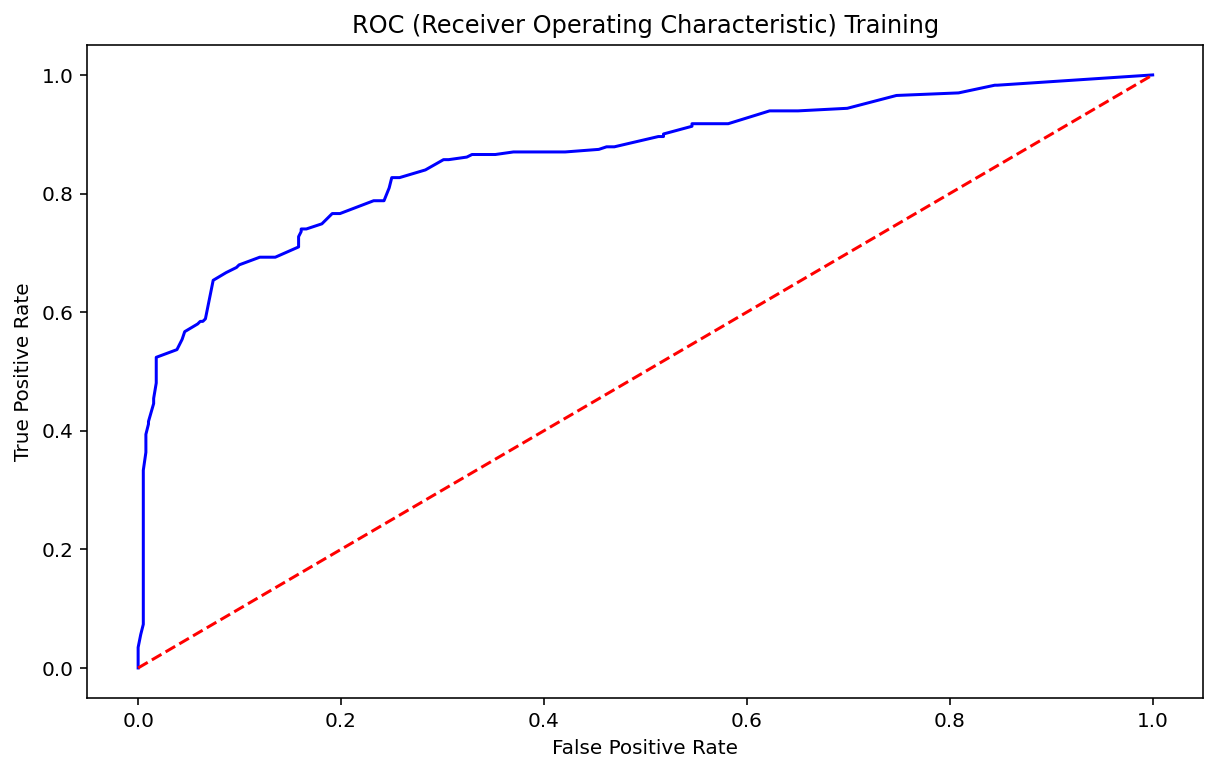

In [23]:
# Plot ROC
plt.figure(figsize = (10, 6))
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f'% auc(fpr, tpr))
plt.plot([0, 1],[0, 1], 'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC (Receiver Operating Characteristic) Training')
plt.show()

In [24]:
# Validation dataset
actual_list = test['Survived'].tolist()
predictions_list = results.predict(sm.add_constant(test[x_cols])).tolist()


fpr, tpr, thresholds = roc_curve(actual_list, predictions_list)

y_test = pd.DataFrame(test['Survived'])
y_test['y_pred'] = results.predict(sm.add_constant(test[x_cols]))
ks = stats.ks_2samp(y_test[y_test['Survived'] == 0]['y_pred'], y_test[y_test['Survived'] == 1]['y_pred']).statistic

print(f'AUC: {auc(fpr, tpr):.4f}')
print(f'GINI: {(2 * auc(fpr, tpr)) - 1:.4f}')
print(f'KS: {ks:.4f}')
print(f'MSE: {mean_squared_error(actual_list, predictions_list):.4f}')

AUC: 0.8303
GINI: 0.6606
KS: 0.5407
MSE: 0.1617


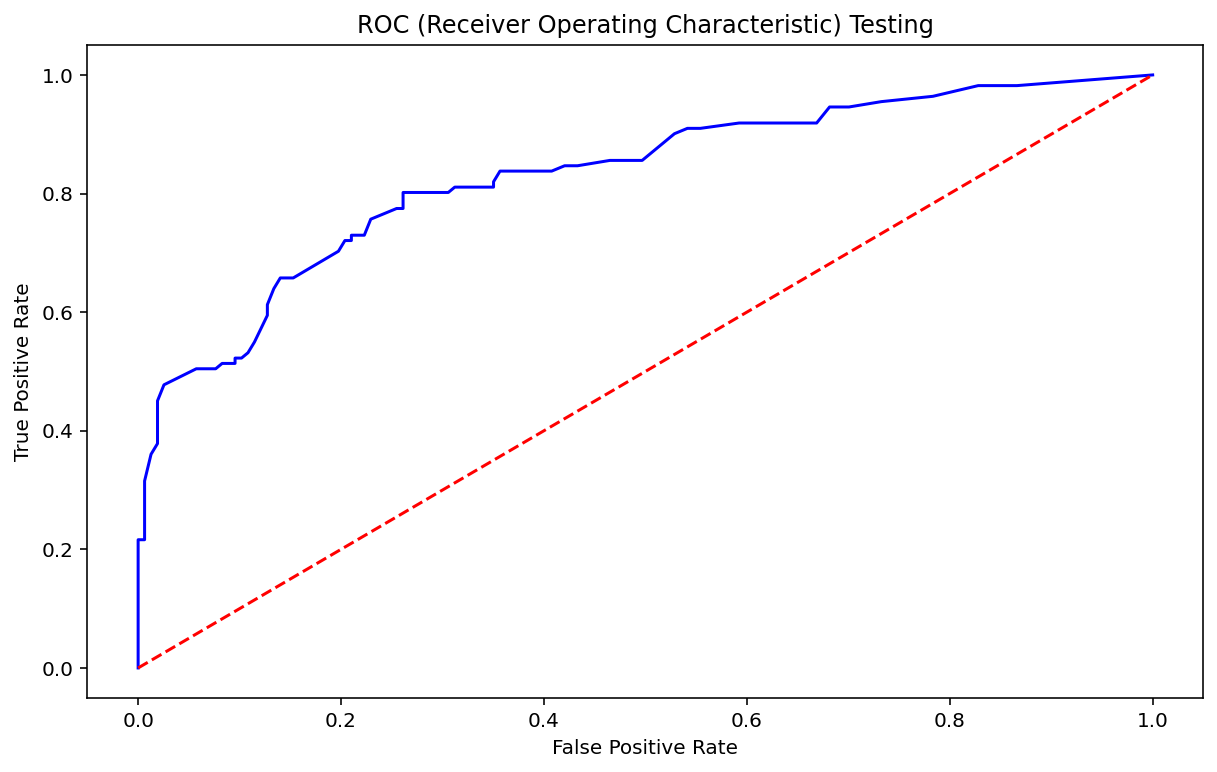

In [25]:
# Plot ROC
plt.figure(figsize = (10, 6))
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f'% auc(fpr, tpr))
plt.plot([0, 1],[0, 1], 'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC (Receiver Operating Characteristic) Testing')
plt.show()

In [26]:
# Score development
# Setting up the parameters
target_score = 600
target_odds = 30
pts_double_odds = 20

# Score calculation
# Training score
train['factor'] = pts_double_odds / np.log(2)
train['offset'] = target_score - train['factor'] * np.log(target_odds)
train['p'] = results.predict()
train['Logit'] = np.log(train['p'] / (1 - train['p']))
train['Score'] = train['offset'] + train['factor'] * train['Logit']
train.head(5)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Age_bin,Fare_bin,SibSp_bin,Parch_bin,WOE_Embarked,WOE_SibSp_bin,WOE_Fare_bin,WOE_Pclass,WOE_Parch_bin,WOE_Age_bin,WOE_Sex,factor,offset,p,Logit,Score
66,67,1,2,female,29.0,0,0,10.5000,S,"(28.0, 32.5]","(8.05, 10.5]",0,0,-0.194425,-0.166057,-0.730685,0.364485,-0.173748,0.144784,1.529877,28.853901,501.862188,0.825223,1.552141,546.647504
381,382,1,3,female,1.0,0,2,15.7417,C,"(0.419, 16.0]","(14.454, 21.679]",0,1,0.688399,-0.166057,0.152380,-0.666483,0.520245,0.673958,1.529877,28.853901,501.862188,0.830947,1.592353,547.807798
223,224,0,3,male,24.0,0,0,7.8958,S,"(20.0, 24.0]","(7.854, 8.05]",0,0,-0.194425,-0.166057,-1.048181,-0.666483,-0.173748,-0.280484,-0.983833,28.853901,501.862188,0.059898,-2.753353,422.417205
629,630,0,3,male,24.0,0,0,7.7333,Q,"(20.0, 24.0]","(7.55, 7.854]",0,0,0.024337,-0.166057,-0.379490,-0.666483,-0.173748,-0.280484,-0.983833,28.853901,501.862188,0.069993,-2.586794,427.223098
337,338,1,1,female,41.0,0,0,134.5000,C,"(38.0, 47.0]","(77.958, 512.329]",0,0,0.688399,-0.166057,1.618420,1.003916,-0.173748,-0.236954,1.529877,28.853901,501.862188,0.928729,2.567326,575.939560


In [27]:
# Validation score
test['factor'] = pts_double_odds / np.log(2)
test['offset'] = target_score - test['factor'] * np.log(target_odds)
test['p'] = results.predict(sm.add_constant(test[x_cols]))
test['Logit'] = np.log(test['p'] / (1 - test['p']))
test['Score'] = test['offset'] + test['factor'] * test['Logit']
test.head(5)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Age_bin,Fare_bin,SibSp_bin,Parch_bin,WOE_Embarked,WOE_SibSp_bin,WOE_Fare_bin,WOE_Pclass,WOE_Parch_bin,WOE_Age_bin,WOE_Sex,factor,offset,p,Logit,Score
890,891,0,3,male,32.0,0,0,7.7500,Q,"(28.0, 32.5]","(7.55, 7.854]",0,0,0.024337,-0.166057,-0.379490,-0.666483,-0.173748,0.144784,-0.983833,28.853901,501.862188,0.099917,-2.198145,438.437124
498,499,0,1,female,25.0,1,2,151.5500,S,"(24.0, 28.0]","(77.958, 512.329]",1,1,-0.194425,0.338810,1.618420,1.003916,0.520245,-0.132848,1.529877,28.853901,501.862188,0.879776,1.990309,559.290371
664,665,1,3,male,20.0,1,0,7.9250,S,"(16.0, 20.0]","(7.854, 8.05]",1,0,-0.194425,0.338810,-1.048181,-0.666483,-0.173748,-0.182119,-0.983833,28.853901,501.862188,0.065164,-2.663458,425.011023
261,262,1,3,male,3.0,4,2,31.3875,S,"(0.419, 16.0]","(27.0, 39.688]",1,1,-0.194425,0.338810,-0.043403,-0.666483,0.520245,0.673958,-0.983833,28.853901,501.862188,0.132263,-1.881097,447.585214
716,717,1,1,female,38.0,0,0,227.5250,C,"(32.5, 38.0]","(77.958, 512.329]",0,0,0.688399,-0.166057,1.618420,1.003916,-0.173748,0.270347,1.529877,28.853901,501.862188,0.953953,3.030944,589.316742


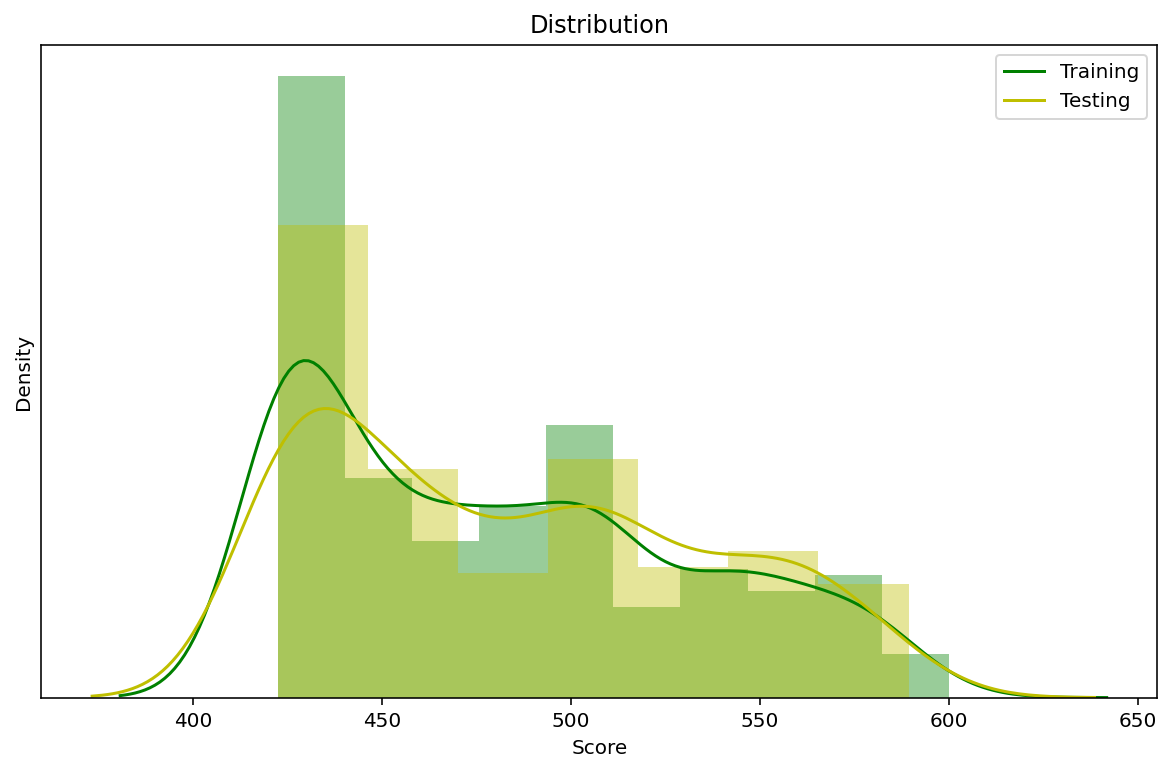

In [28]:
# Plot score
plt.figure(figsize = (10, 6))
sns.distplot(train['Score'], color = 'g')
sns.distplot(test['Score'], color = 'y')
plt.yticks([])
plt.legend(('Training','Testing'))
plt.title('Distribution')
plt.show()

In [29]:
# Score rank development
ranking = pd.qcut(
    train['Score'],
    10,
    duplicates = 'drop'
)
ranking = pd.DataFrame(ranking)
ranking = ranking.rename(columns = {'Score': 'Binning'})
train = pd.merge(
    train,
    ranking,
    how = 'left',
    left_index = True,
    right_index = True
)

# Show table
train.head(5)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Age_bin,Fare_bin,SibSp_bin,Parch_bin,WOE_Embarked,WOE_SibSp_bin,WOE_Fare_bin,WOE_Pclass,WOE_Parch_bin,WOE_Age_bin,WOE_Sex,factor,offset,p,Logit,Score,Binning
66,67,1,2,female,29.0,0,0,10.5000,S,"(28.0, 32.5]","(8.05, 10.5]",0,0,-0.194425,-0.166057,-0.730685,0.364485,-0.173748,0.144784,1.529877,28.853901,501.862188,0.825223,1.552141,546.647504,"(533.6, 556.545]"
381,382,1,3,female,1.0,0,2,15.7417,C,"(0.419, 16.0]","(14.454, 21.679]",0,1,0.688399,-0.166057,0.152380,-0.666483,0.520245,0.673958,1.529877,28.853901,501.862188,0.830947,1.592353,547.807798,"(533.6, 556.545]"
223,224,0,3,male,24.0,0,0,7.8958,S,"(20.0, 24.0]","(7.854, 8.05]",0,0,-0.194425,-0.166057,-1.048181,-0.666483,-0.173748,-0.280484,-0.983833,28.853901,501.862188,0.059898,-2.753353,422.417205,"(422.416, 426.31]"
629,630,0,3,male,24.0,0,0,7.7333,Q,"(20.0, 24.0]","(7.55, 7.854]",0,0,0.024337,-0.166057,-0.379490,-0.666483,-0.173748,-0.280484,-0.983833,28.853901,501.862188,0.069993,-2.586794,427.223098,"(426.31, 436.942]"
337,338,1,1,female,41.0,0,0,134.5000,C,"(38.0, 47.0]","(77.958, 512.329]",0,0,0.688399,-0.166057,1.618420,1.003916,-0.173748,-0.236954,1.529877,28.853901,501.862188,0.928729,2.567326,575.939560,"(556.545, 599.96]"


In [30]:
# Score by factors
# Define function to remove variables
def remove(x):
  return x[4:]

x_cols2 = [remove(x) for x in x_cols]

factors_final = factors_summary2.set_index('Factors').loc[x_cols2]
factors_final = factors_final[['Binning','WOE']]
factors_final['const'] = results.params[0]
factors_final['n'] = len(results.params) - 1
factors_final['factor'] = pts_double_odds / np.log(2)
factors_final['offset'] = target_score - factors_final['factor'] * np.log(target_odds)

coff = pd.DataFrame(results.params[1:], columns = ['coff'])
coff_names = [remove(x) for x in coff.index]
coff['Factors'] = coff_names
coff = coff.set_index(coff['Factors']).drop(['Factors'], axis = 1)

factors_final = pd.merge(
    factors_final,
    coff,
    how = 'left',
    left_index = True,
    right_index = True
)

factors_final['Score'] = factors_final['offset'] / factors_final['n'] + \
                         factors_final['factor'] * \
                         (factors_final['WOE'] * factors_final['coff'] + factors_final['const'] / factors_final['n'])

# Show table
factors_final.head(5)

,Binning,WOE,const,n,factor,offset,coff,Score
Factors,,,,,,,,
Age_bin,"(0.419, 16.0]",0.673958,-0.531439,4,28.853901,501.862188,0.913891,139.403860
Age_bin,"(16.0, 20.0]",-0.182119,-0.531439,4,28.853901,501.862188,0.913891,116.829668
Age_bin,"(20.0, 24.0]",-0.280484,-0.531439,4,28.853901,501.862188,0.913891,114.235851
Age_bin,"(24.0, 28.0]",-0.132848,-0.531439,4,28.853901,501.862188,0.913891,118.128913
Age_bin,"(28.0, 32.5]",0.144784,-0.531439,4,28.853901,501.862188,0.913891,125.449876


In [31]:
# Find maximum score
max_score = train[train['Score'] == train['Score'].max()]
max_score

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Age_bin,Fare_bin,SibSp_bin,Parch_bin,WOE_Embarked,WOE_SibSp_bin,WOE_Fare_bin,WOE_Pclass,WOE_Parch_bin,WOE_Age_bin,WOE_Sex,factor,offset,p,Logit,Score,Binning
329,330,1,1,female,16.0,0,1,57.9792,C,"(0.419, 16.0]","(39.688, 77.958]",0,1,0.688399,-0.166057,0.585766,1.003916,0.520245,0.673958,1.529877,28.853901,501.862188,0.967698,3.399801,599.959708,"(556.545, 599.96]"
